### Important 
This notebook is used to run code (like a main.py) __only__.

All methods must be written in separate .py files. 

Allowed here: Imports, data loading, data cleaning, method calling. 

In order for the first part to work, we assume that the run.sh has been executed.

# Building a Text Classifier

### Imports

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn import model_selection, linear_model
import re
import seaborn as sns
import string
import nltk
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline
from nltk.stem.porter import *


### Define Constants

In [2]:
DATA_FOLDER = 'data/'
TWITTER_FOLDER = 'twitter-datasets/'

### Load datasets

In [3]:
#read_table automatically uses the new line as a separator. 
#use partial files for now
train_neg_r = open(DATA_FOLDER+TWITTER_FOLDER+"train_neg.txt").readlines()
train_pos_r = open(DATA_FOLDER+TWITTER_FOLDER+"train_pos.txt").readlines()
test_r = open(DATA_FOLDER+TWITTER_FOLDER+"test_data.txt").readlines()

### Create DataFrame with labels

In [4]:
#Create DataFrames for positive and negative 
train_pos = pd.DataFrame()
train_pos['tweet'] = train_pos_r
train_pos['label'] = 1
train_neg = pd.DataFrame()
train_neg['tweet'] = train_neg_r
train_neg['label'] = 0

#Merge them together
tweets = pd.concat([train_pos, train_neg], ignore_index=True)
tweets.index.name = 'id'

In [5]:
def remove_pattern(text, pattern):
    matches = re.findall(pattern, text)
    for match in matches:
        text = re.sub(match, '', text)
    return text

### Remove < user >

In [6]:
tweets['clean_tweet'] = np.vectorize(remove_pattern)(tweets['tweet'], "<user>")

### Remove special chars, numbers and punctuations

In [7]:
#replace special characters, numbers and punctuations, except chars & hashtags
tweets['clean_tweet'] = tweets['clean_tweet'].str.replace("[^a-zA-Z#]", " ")

### Tokenize tweets

In [8]:
#tokenize tweets 
tokenized_tweets = tweets['clean_tweet'].apply(lambda x: x.split())
#tokenized_tweets.head()

### Stemming

Warning: Step below takes time for full data set!

In [9]:
#stemming
stemmer = PorterStemmer()
stemmed_tokenized_tweets = tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

In [10]:
stem = stemmed_tokenized_tweets.copy()

Stich tokens back together

In [11]:
for i in range(len(stem)):
    stem[i] = ' '.join(stem[i])

In [12]:
tweets['clean_tweet'] = stem

In [13]:
tweets.head()

,tweet,label,clean_tweet
id,,,
0,<user> i dunno justin read my mention or not ....,1,i dunno justin read my mention or not onli jus...
1,"because your logic is so dumb , i won't even c...",1,becaus your logic is so dumb i won t even crop...
2,""" <user> just put casper in a box ! "" looved t...",1,just put casper in a box loov the battl #crakk...
3,<user> <user> thanks sir > > don't trip lil ma...,1,thank sir don t trip lil mama just keep doin y...
4,visiting my brother tmr is the bestest birthda...,1,visit my brother tmr is the bestest birthday g...


### Plot word clouds to get a feeling of the words

In [14]:
all_words = ' '.join([text for text in tweets['clean_tweet']])

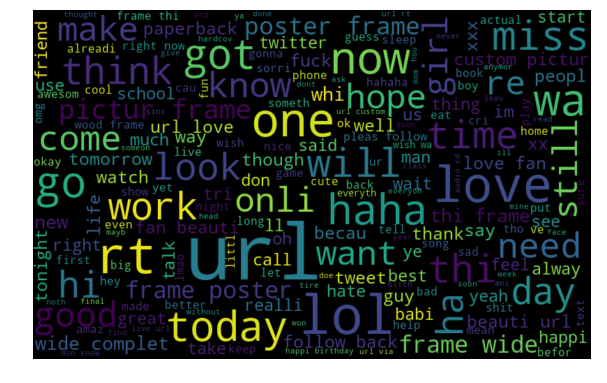

In [15]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [16]:
positive_words = ' '.join([text for text in tweets['clean_tweet'][tweets['label'] == 1]])

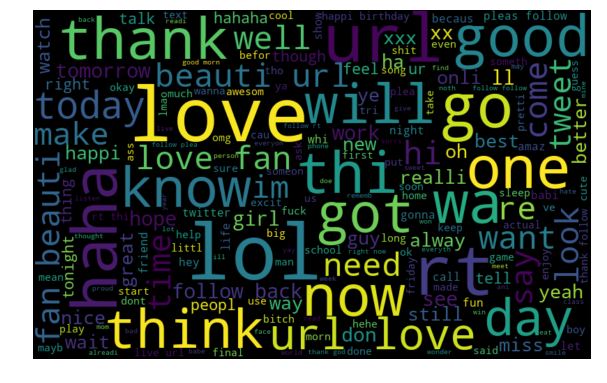

In [17]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [18]:
negative_words = ' '.join([text for text in tweets['clean_tweet'][tweets['label'] == 0]])

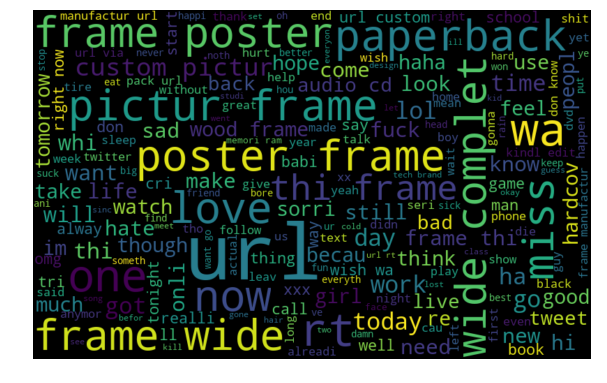

In [19]:
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Remove stop words

In [20]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
  
stop_words = set(stopwords.words('english')) 
  
tweets['clean_tweet_no_stop'] = tweets['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

### Extract hashtags

In [21]:
# function to collect hashtags
def extract_hashtags(tweets):
    hashtags = []
    # Loop over the words in the tweet
    for tweet in tweets:
        hashtag = re.findall(r"#(\w+)", tweet)
        hashtags.append(hashtag)
    return hashtags

In [22]:
#extract positive hashtags
positive_hashtags = extract_hashtags(tweets['clean_tweet_no_stop'][tweets['label']==1])
#unnest
positive_hashtags = sum(positive_hashtags, [])

In [23]:
#extract negative hashtags
negative_hashtags = extract_hashtags(tweets['clean_tweet_no_stop'][tweets['label']==0])
#unnest
negative_hashtags = sum(negative_hashtags, [])

### Plot top n hashtags


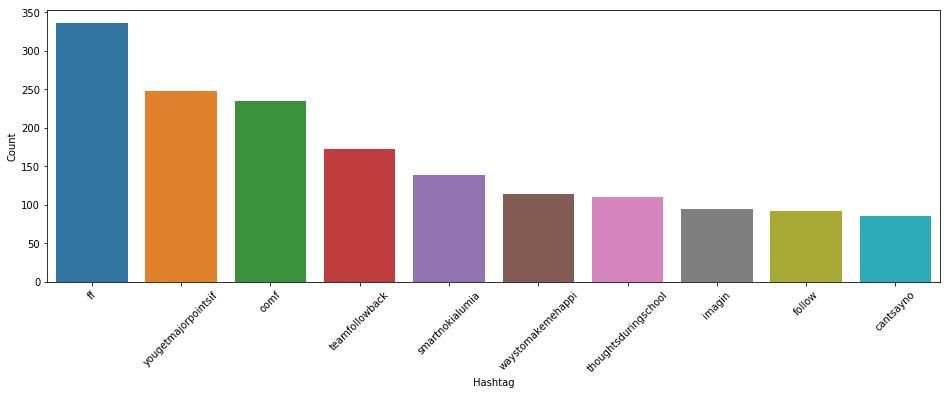

In [24]:
#plot top n hashtags
pos = nltk.FreqDist(positive_hashtags)
pos_df = pd.DataFrame({'Hashtag': list(pos.keys()),
                  'Count': list(pos.values())})

# selecting top 10 most frequent hashtags     
pos_df = pos_df.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=pos_df, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=45)
plt.show()

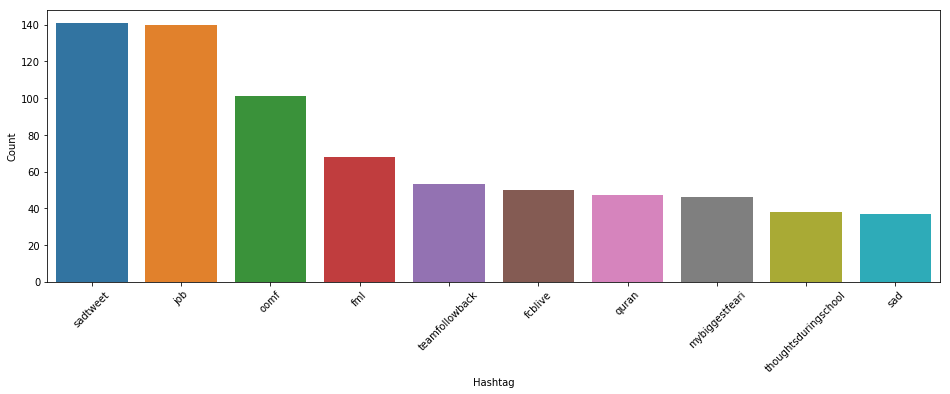

In [25]:
neg = nltk.FreqDist(negative_hashtags)
neg_df = pd.DataFrame({'Hashtag': list(neg.keys()), 'Count': list(neg.values())})
# selecting top 10 most frequent hashtags
neg_df = neg_df.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=neg_df, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=45)
plt.show()

In [26]:
tweets.head()

,tweet,label,clean_tweet,clean_tweet_no_stop
id,,,,
0,<user> i dunno justin read my mention or not ....,1,i dunno justin read my mention or not onli jus...,dunno justin read mention onli justin god know...
1,"because your logic is so dumb , i won't even c...",1,becaus your logic is so dumb i won t even crop...,becaus logic dumb even crop name photo tsk url
2,""" <user> just put casper in a box ! "" looved t...",1,just put casper in a box loov the battl #crakk...,put casper box loov battl #crakkbitch
3,<user> <user> thanks sir > > don't trip lil ma...,1,thank sir don t trip lil mama just keep doin y...,thank sir trip lil mama keep doin ya thang
4,visiting my brother tmr is the bestest birthda...,1,visit my brother tmr is the bestest birthday g...,visit brother tmr bestest birthday gift eveerrr
